In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import Imputer

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_log_error
from dateutil.parser import parse
from sklearn.base import TransformerMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [6]:
class Transform(TransformerMixin):
    def fit(self, X, y=None):
        self.encoders = dict()
        for column in X.columns:
            if X.dtypes[column] == object:
                self.encoders[column] = preprocessing.LabelEncoder()
                self.encoders[column] = self.encoders[column].fit(X[column]) 
                
            
    def transform(self, X, y=None):
        X = X.drop(['id'], axis=1)
        X = X.fillna(X.mean(axis = 0))
        X['timestamp'] = X.timestamp.apply(lambda x : parse(x).timestamp())
        for column in self.encoders:
            if column != 'timestamp':
                X[column] = X[column].fillna(X[column].value_counts().index[0])
                X[column] = self.encoders[column].transform(X[column])
        return X

In [3]:
class Scaler(TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = dict()
        for column in X.columns:
            if column != 'price_doc':
                self.scaler[column] = StandardScaler()
                self.scaler[column] = self.scaler[column].fit(X[column].values.reshape(-1,1)) 

            
    def transform(self, X, y=None):
        for column in self.scaler:
            X[column] = self.scaler[column].transform(X[column].values.reshape(-1,1))
        return X


In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [9]:
transf = Transform()
transf.fit(train)
train = transf.transform(train)
test = transf.transform(test)

scale = Scaler()
scale.fit(train)
train = scale.transform(train)
test = scale.transform(test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
target = ['price_doc']
predictors = [col for col in train.columns if col not in target]

In [11]:
booster = XGBRegressor()
parameters = {'max_depth': range(2,8)}
clf = GridSearchCV(booster,parameters)
clf.fit(train[predictors], train[target])
maxdepth = clf.best_params_['max_depth']


[]

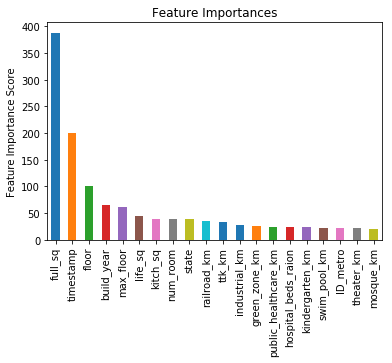

In [13]:
booster = XGBRegressor(max_depth = maxdepth)
clf = booster.fit(train[predictors], train[target])
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)[0:20]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

In [14]:
predictors = list(feat_imp.keys())

In [16]:
class Reg_model(TransformerMixin):
    def fit(self, X, y):
        regressor = Lasso()
        data = X[['full_sq']]

        parameters = {'alpha': np.linspace(0.01, 90, 100)}
        clf = GridSearchCV(regressor, parameters)
        clf.fit(data, train[target])
        alfa = clf.best_params_['alpha']

        regressor = Lasso(alpha = alfa)
        self.reg = regressor.fit(data, y)
        return self
    
    def transform(self, X, y= None):
        data = X[['full_sq']]
        self.price = self.reg.predict(data)
        X['linear_price'] = self.price
        return X

In [17]:
#Pipeline
from sklearn.pipeline import Pipeline
import pickle

lasso = Reg_model()
booster = XGBRegressor(max_depth = maxdepth)

pipe = Pipeline([('Lasso', lasso), ('XGB', booster)])
pipe = pipe.fit(train[predictors],train[target])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
price_train = pipe.predict(train[predictors])
print('MSLE for train is:',mean_squared_log_error(price_train,train[target]))

MSLE for train is: 0.20832612846189608


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
price_test = pipe.predict(test[predictors])
print('Test price:', price_test)

Test price: [5596938.5 8813300.  5773667.5 ... 4989141.  5422178.  9181172. ]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
file = pd.read_csv('sample_submission.csv')
file.price_doc = price_test
file.to_csv('sample_submission.csv',index=False)